# Moving Averages CINGULATE region

This corresponds to the visualization on the first HCP half of the t-SNE and K-means clustering with 10 clusters of the two models (first model being run on the first half, the second model being run on the second half of HCP)

# 1) Imports

In [45]:
import os
import glob
import sys
import json
import shutil

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [46]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

import torch

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.manifold import TSNE

import matplotlib.cm as cm

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig

In [47]:
save_mesh = False

# 2) Functions and datasets

In [48]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(0, len(df.columns))]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [49]:
def mscatter(x, y, ax=None, m=None, **kw):
    if not ax:
        ax = plt.gca()
    sc = ax.scatter(x, y, **kw)
    if (m is not None) and (len(m) == len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [50]:
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

In [51]:
if torch.cuda.is_available():
    device = "cuda:0"
print(device)

cuda:0


In [52]:
run_dir = '/host/volatile/jc225751/Runs/29_MIDL_2022_clean'

In [53]:
# We load the embeddings
result_dir = f"{run_dir}/Output/t-0.1/n-004_o-4"
train_val_embeddings_file = f"{result_dir}/train_val_embeddings.pt"
embeddings = torch.load(train_val_embeddings_file)
print(embeddings.shape)

torch.Size([550, 4])


In [54]:
# We load the embeddings from the second half
result_dir2 = f"{run_dir}/Output/t-0.1/n-004_o-4_2nde_half"
train_val_embeddings_file2 = f"{result_dir2}/train_val_embeddings.pt"
embeddings2 = torch.load(train_val_embeddings_file2)
print(embeddings2.shape)

torch.Size([550, 4])


In [55]:
# We load the labels
with open(f"{result_dir}/train_val_filenames.json", 'r') as f:
    subject_labels = json.load(f)
print(subject_labels[0])    

129634


# 3) T-SNE and different clusterings

In [56]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=50)
X_tsne = tsne.fit_transform(embeddings)

In [57]:
tsne2 = TSNE(n_components=2, perplexity=25, init='pca', random_state=50)
X_tsne2 = tsne2.fit_transform(embeddings2)

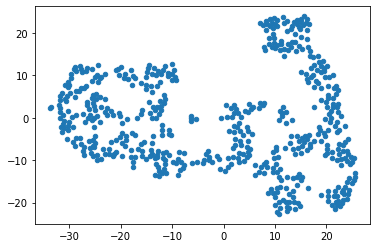

In [58]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], s=20, ax=ax)
plt.show()


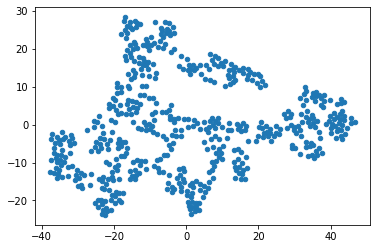

In [59]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], s=20, ax=ax)
plt.show()

In [60]:
X_tsne.shape 

(550, 2)

In [61]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne)
cluster_labels_kmeans = kmeans.labels_
x_cluster_label_kmeans = kmeans.predict(X_tsne)
clusters_centers_kmeans = kmeans.cluster_centers_
print(f"clusters centroids = {clusters_centers_kmeans.shape}")
print(f"Average silhouette score: {metrics.silhouette_score(X_tsne, cluster_labels_kmeans)}")


clusters centroids = (10, 2)
Average silhouette score: 0.4572193920612335


In [62]:
kmeans2 = KMeans(n_clusters=10, random_state=0).fit(X_tsne2)
cluster_labels_kmeans2 = kmeans2.labels_
x_cluster_label_kmeans2 = kmeans2.predict(X_tsne2)
clusters_centroids_kmeans2 = kmeans2.cluster_centers_
print(f"clusters centroids = {clusters_centroids_kmeans2.shape}")
print(f"Average silhouette score: {metrics.silhouette_score(X_tsne2, cluster_labels_kmeans2)}")

clusters centroids = (10, 2)
Average silhouette score: 0.45353755354881287


In [63]:
def coloring_kmeans(labels):
    """Returns a list of colors corresponding to labels"""
#    color_dict = {0: 'black', 1:'brown', 2:'darkorange', 3:'gold', 4:'yellowgreen',
#                  5: 'forestgreen', 6:'turquoise', 7:'dodgerblue', 8:'blue',
#                  9:'magenta'}
    color_dict = {0: 'yellowgreen', 1:'darkorange', 2:'blue', 3:'brown', 4:'turquoise',
                  5: 'gold', 6:'magenta', 7:'dodgerblue', 8:'forestgreen',
                  9:'black'}
    colors_list = [color_dict[lab] for lab in labels]
    return colors_list

def coloring_kmeans_new_label(labels):
    """Returns a list of colors corresponding to labels"""
    color_dict = {0: 'black', 1:'brown', 2:'darkorange', 3:'gold', 4:'yellowgreen',
                  5: 'forestgreen', 6:'turquoise', 7:'dodgerblue', 8:'blue',
                  9:'magenta'}
    colors_list = [color_dict[lab] for lab in labels]
    return colors_list

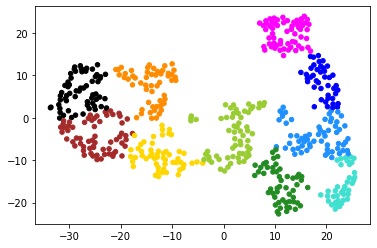

In [64]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=coloring_kmeans(x_cluster_label_kmeans), s=20, ax=ax)
plt.show()

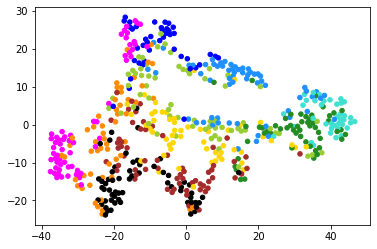

In [65]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], c=coloring_kmeans(x_cluster_label_kmeans), s=20, ax=ax)
plt.show()

In [66]:
cluster_kmeans_new_label_inv = {0:9, 1:3, 2:1, 3:5, 4:0, 5:8, 6:4, 7:7, 8:2, 9:6}
cluster_kmeans_new_label = {0:4, 1:2, 2:8, 3:1, 4:6, 5:3, 6:9, 7:7, 8:5, 9:0}

In [67]:
x_cluster_label_kmeans = [cluster_kmeans_new_label[lab] for lab in x_cluster_label_kmeans]
cluster_labels_kmeans = [cluster_kmeans_new_label[lab] for lab in cluster_labels_kmeans]
print(clusters_centers_kmeans)
temp = np.zeros(clusters_centers_kmeans.shape)
for i in range(clusters_centers_kmeans.shape[0]):
    temp[i] = clusters_centers_kmeans[cluster_kmeans_new_label_inv[i]]
clusters_centers_kmeans = temp
print(clusters_centers_kmeans)

[[  1.932714   -4.0915556]
 [-14.140398    7.4624553]
 [ 19.195377    8.438675 ]
 [-24.68092    -4.352781 ]
 [ 23.025106  -15.978607 ]
 [-12.144989   -8.933054 ]
 [ 12.112993   19.846977 ]
 [ 18.010944   -4.2441235]
 [ 11.172321  -15.83111  ]
 [-27.81254     6.0992756]]
[[-27.81254005   6.09927559]
 [-24.68091965  -4.35278082]
 [-14.14039803   7.46245527]
 [-12.14498901  -8.93305397]
 [  1.93271399  -4.0915556 ]
 [ 11.17232132 -15.83111   ]
 [ 23.02510643 -15.97860718]
 [ 18.01094437  -4.24412346]
 [ 19.19537735   8.43867493]
 [ 12.11299324  19.84697723]]


# 3b) Accuracy and ARI score

In [68]:
metrics.accuracy_score(x_cluster_label_kmeans, x_cluster_label_kmeans2)

0.17454545454545456

In [69]:
metrics.adjusted_rand_score(x_cluster_label_kmeans, x_cluster_label_kmeans2)

0.27678447657703237

# 4) Creation of buckets dictionnary

In [70]:
dstrb_sub = pd.DataFrame(X_tsne, index=subject_labels, columns=[0,1])
dstrb_sub['kmeans_label'] = x_cluster_label_kmeans

In [71]:
dstrb_sub.head()

,0,1,kmeans_label
129634,-25.234621,-6.989079,1
136833,-19.723698,-9.008698,1
206222,22.822351,-11.067300,6
138837,20.976093,-0.183199,7
987983,18.855858,10.753638,8


In [72]:
clusters = []
for lab in np.unique([dstrb_sub.kmeans_label]):
    cluster_df = dstrb_sub[dstrb_sub.kmeans_label==lab]
    clusters.append(cluster_df)
for lab in np.unique([dstrb_sub.kmeans_label]):
    assert(len(np.unique(list(clusters[lab].kmeans_label)))==1)

In [73]:
bucket_path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rbuckets/'
suffix_path = '_normalized.bck'
buckets = {}
for sub in tqdm(list(subject_labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    bucket = dtx.convert.bucket_aims_to_ndarray(bucket[0])
    buckets[sub] = bucket

100%|██████████| 550/550 [00:27<00:00, 19.93it/s]


In [74]:
subjects = []
for lab in range(len(clusters_centers_kmeans)):
    subject = clusters[lab].index
    subjects.append(subject)

In [75]:
buckets_c = []
for lab in range(len(subjects)):
    bucket_c = {k: v for k,v in buckets.items() if k in list(subjects[lab])}
    buckets_c.append(bucket_c)

In [76]:
cld.draw(list(buckets_c[0].values())[0])

In [77]:
def subj_count_extreme_coords(isodf, axis, min_coord, max_coord, num_coord=10):
    coord_values = np.linspace(min_coord, max_coord, num_coord)
    step = (coord_values[1] - coord_values[0])
    midpoint_min = coord_values[0] + step/2
    midpoint_max = coord_values[num_coord-1] - step/2
    coord_under = [elt for elt in isodf[axis] if elt<midpoint_min]
    coord_over = [elt for elt in isodf[axis] if elt>midpoint_max]
    num_subj_under = len(coord_under)
    num_subj_over = len(coord_over)
    return num_subj_under, num_subj_over

def get_MA_coords(isodf, axis, num_subj_threshold, num_coord=10):
    min_subj_coord = min(isodf[axis])
    max_subj_coord = max(isodf[axis])
    step = (max_subj_coord - min_subj_coord)/num_coord
    num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    while ((num_subj_under<num_subj_threshold)|(num_subj_over<num_subj_threshold)):
        step = (max_subj_coord - min_subj_coord)/num_coord
        if num_subj_under<num_subj_threshold:
            min_subj_coord = min_subj_coord + step
        if num_subj_over<num_subj_threshold:
            max_subj_coord = max_subj_coord - step
        num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    return np.linspace(min_subj_coord, max_subj_coord, num_coord)

In [78]:
clusters[0].head()

,0,1,kmeans_label
206525,-23.967800,9.302140,0
131621,-24.388103,8.488575,0
887373,-27.278805,0.862057,0
770352,-31.702448,4.195551,0
211316,-30.125883,1.625984,0


# 5) MA with Kmeans

In [79]:
dstrb_sub.head()

,0,1,kmeans_label
129634,-25.234621,-6.989079,1
136833,-19.723698,-9.008698,1
206222,22.822351,-11.067300,6
138837,20.976093,-0.183199,7
987983,18.855858,10.753638,8


In [80]:
clusters_centers_kmeans

array([[-27.81254005,   6.09927559],
       [-24.68091965,  -4.35278082],
       [-14.14039803,   7.46245527],
       [-12.14498901,  -8.93305397],
       [  1.93271399,  -4.0915556 ],
       [ 11.17232132, -15.83111   ],
       [ 23.02510643, -15.97860718],
       [ 18.01094437,  -4.24412346],
       [ 19.19537735,   8.43867493],
       [ 12.11299324,  19.84697723]])

In [81]:
n_clusters_kmeans = clusters_centers_kmeans.shape[0]

In [82]:
central_kmeans = []
for i in range(n_clusters_kmeans):
    central_kmeans.append(closest_distance(clusters_centers_kmeans[i], dstrb_sub.drop(['kmeans_label'], axis=1)))
    print(f"Closest subject to centroid of cluster {i} is {central_kmeans[i]}")

Closest subject to centroid of cluster 0 is 761957
Closest subject to centroid of cluster 1 is 583858
Closest subject to centroid of cluster 2 is 136631
Closest subject to centroid of cluster 3 is 894067
Closest subject to centroid of cluster 4 is 159946
Closest subject to centroid of cluster 5 is 826353
Closest subject to centroid of cluster 6 is 152831
Closest subject to centroid of cluster 7 is 962058
Closest subject to centroid of cluster 8 is 206323
Closest subject to centroid of cluster 9 is 891667


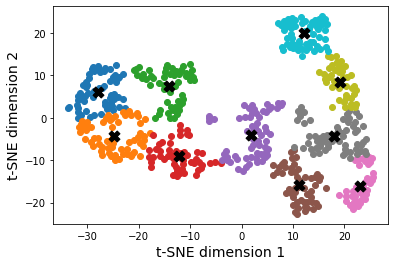

In [83]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[0:2]]) for i in range(len(dstrb_sub))])

# color_dict = {0: 'blue', 1:'red', 2:'green', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.kmeans_label]):
    ix = np.where(dstrb_sub.kmeans_label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, label = g)

for g in np.unique([dstrb_sub.kmeans_label]):
    ax.scatter(clusters_centers_kmeans[g][0],
               clusters_centers_kmeans[g][1],
               color='black',
               marker='X',
               s=120)

plt.xlabel(f't-SNE dimension 1', fontsize=14)
plt.ylabel(f't-SNE dimension 2', fontsize=14)
plt.show()

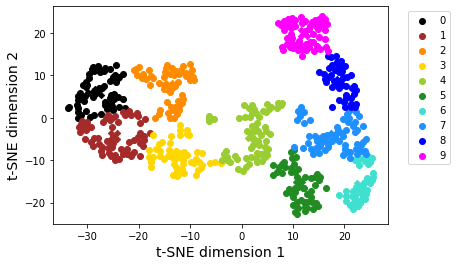

In [84]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[0:2]]) for i in range(len(dstrb_sub))])
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.kmeans_label]):
    # print(g)
    # print(coloring_kmeans([g]))
    ix = np.where(dstrb_sub.kmeans_label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = coloring_kmeans_new_label([g]), label = g)

for g in np.unique([dstrb_sub.kmeans_label]):
    ax.scatter(clusters_centers_kmeans[g][0],
               clusters_centers_kmeans[g][1],
               color=coloring_kmeans_new_label([g]),
               marker='X',
               s=150)

plt.xlabel(f't-SNE dimension 1', fontsize=14)
plt.ylabel(f't-SNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.show()

In [85]:
clusters[0].index 

Index(['206525', '131621', '887373', '770352', '211316', '571144', '180937',
       '101107', '129937', '161832', '104820', '118932', '654754', '113922',
       '761957', '173435', '159340', '683256', '154835', '119833', '164030',
       '199655', '634748', '176845', '499566', '561242', '182840', '105620',
       '210011', '197651', '942658', '201111', '211821', '114318', '814548',
       '115320', '113821', '580751', '171431', '146836', '540436', '124422',
       '181232', '951457', '201818', '208125', '162329', '167036', '153227',
       '103111', '129129', '588565', '111312', '733548', '123117', '919966',
       '943862', '189450', '933253', '352132', '792867'],
      dtype='object')

In [86]:
aligned_buckets_kmeans = []
aligned_rot_kmeans = []
aligned_transl_kmeans = []

for lab in range(n_clusters_kmeans):
    print(lab)
    buck, rot, trans = ma.align_buckets_by_ICP_batch(buckets_c[lab], central_kmeans[lab])
    aligned_buckets_kmeans.append(buck)
    aligned_rot_kmeans.append(rot)
    aligned_transl_kmeans.append(trans)

>>> INFO moving_averages.transform - using 45 cores out of 48


0


Aligning buckets to 761957: 100%|██████████| 61/61 [00:00<00:00, 112.15it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


1


Aligning buckets to 583858: 100%|██████████| 63/63 [00:00<00:00, 101.51it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


2


Aligning buckets to 136631: 100%|██████████| 54/54 [00:00<00:00, 113.37it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


3


Aligning buckets to 894067: 100%|██████████| 54/54 [00:00<00:00, 103.83it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


4


Aligning buckets to 159946: 100%|██████████| 63/63 [00:00<00:00, 78.97it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


5


Aligning buckets to 826353: 100%|██████████| 53/53 [00:00<00:00, 108.67it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


6


Aligning buckets to 152831: 100%|██████████| 38/38 [00:00<00:00, 111.14it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


7


Aligning buckets to 962058: 100%|██████████| 62/62 [00:00<00:00, 104.07it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


8


Aligning buckets to 206323: 100%|██████████| 42/42 [00:00<00:00, 121.38it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


9


Aligning buckets to 891667: 100%|██████████| 60/60 [00:00<00:00, 110.23it/s]


In [87]:
FWHM = [100.]*10
SPAM_vols_kmeans = [[], []]
shift_kmeans = [[], []]
for ax in [0, 1]:
    for i in range(n_clusters_kmeans):
        vol_1, shift_1 = ma.moving_averages_tools.calc_one_MA_volume(
            buckets_dict=aligned_buckets_kmeans[i], 
            distance_df=clusters[i],
            axis_n=ax,
            center=clusters_centers_kmeans[i][ax],
            FWHM=FWHM[i])
        SPAM_vols_1 = dict({clusters_centers_kmeans[i][ax]:vol_1})
        SPAM_vols_kmeans[ax].append(SPAM_vols_1)
        shift_kmeans[ax].append(shift_1)


In [88]:
SPAM_meshes_kmeans = [[], []]
# thresholds = [0.6, 0.65, 0.57, 0.62]
threshold = '88%'

for ax in [0, 1]:
    for i in range(n_clusters_kmeans):
        SPAM_mesh_1 = {}

        for k, volume in tqdm(list(SPAM_vols_kmeans[ax][i].items())[:]):
            SPAM_mesh_1[k]=dtx.convert.volume_to_mesh(
                            vol=volume,
                            gblur_sigma=0.3,
                            threshold=threshold,
                            deciReductionRate=0,
                            smoothRate=0.1)
        SPAM_meshes_kmeans[ax].append(SPAM_mesh_1)


100%|██████████| 1/1 [00:00<00:00, 26.31it/s]


In [89]:
fig = cld.draw(list(SPAM_vols_kmeans[0][0].values())[0], th_min=0.2)
cld.draw(list(SPAM_meshes_kmeans[0][0].values())[0], fig=fig)

In [90]:
SPAM_shift_meshes_kmeans = [[], []]
for ax in [0, 1]:
    for i in range(n_clusters_kmeans):
        SPAM_mesh_1 = {}
        for dist, mesh in SPAM_meshes_kmeans[ax][i].items():
            SPAM_mesh_1[str(dist)] = \
                dtx.mesh.shift_aims_mesh_along_axis(
                    mesh, 0., axis=0, scale=1)
        SPAM_shift_meshes_kmeans[ax].append(SPAM_mesh_1)

In [91]:
if save_mesh:
    for ax in [0, 1]:
        for i in range(n_clusters_kmeans):
            SPAM_shift_mesh = SPAM_shift_meshes_kmeans[ax][i]
            for _, mesh in SPAM_shift_mesh.items():
                mesh_file = f"{result_dir}/kmeans_cluster_ax{ax}_{i}.mesh"
                print(mesh_file)
                aims.write(mesh, mesh_file)
                del mesh